# Room Impulse Response Generation with GAN

Reference:

Ratnarajah, A., Tang, Z., & Manocha, D. (2021). IR-GAN: Room impulse response generator for far-field speech recognition. Proc. Interspeech.

https://github.com/anton-jeran/IR-GAN 


In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
from torchinfo import summary
import torch.autograd as autograd

import numpy as np
import librosa

import matplotlib.pyplot as plt
import IPython.display as ipd

## Introduction of the concept of GAN

Generative Adversarial Networks (GANs) are a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014. GANs consist of two neural networks, a Generator (G) and a Discriminator (D), which are trained simultaneously through adversarial processes.

The Generator's goal is to generate realistic data samples from random noise. It learns to map the input noise vector \( \mathbf{z} \) to the data space, producing synthetic data samples that resemble the real data.

The Discriminator's goal is to distinguish between real data samples and the synthetic data samples generated by the Generator. It outputs a probability indicating whether a given sample is real or fake.

During training, the Generator and Discriminator play a minimax game. The Generator tries to fool the Discriminator by generating realistic samples, while the Discriminator tries to correctly identify real and fake samples. The objective functions for the Generator and Discriminator are as follows:

#### Discriminator Loss
The Discriminator aims to maximize the probability of correctly classifying real and fake samples. The loss function for the Discriminator is given by:

$$ \mathcal{L}_D = -\mathbb{E}_{\mathbf{x} \sim p_{\text{data}}(\mathbf{x})} [\log D(\mathbf{x})] - \mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log (1 - D(G(\mathbf{z})))] $$

#### Generator Loss
The Generator aims to minimize the probability that the Discriminator correctly classifies the generated samples as fake. The loss function for the Generator is given by:

$$ \mathcal{L}_G = -\mathbb{E}_{\mathbf{z} \sim p_{\mathbf{z}}(\mathbf{z})} [\log D(G(\mathbf{z}))] $$

### Training Process
The training process involves alternating between updating the Discriminator and the Generator. The Discriminator is trained to maximize its ability to distinguish real from fake samples, while the Generator is trained to minimize the Discriminator's ability to do so.

GANs have been widely used in various applications, including image generation, image-to-image translation, text-to-image synthesis, and more. They have shown remarkable success in generating high-quality and realistic data samples.


## Dataset

In this tutorial, we will use GAN to generate room impulse responses.

In [3]:
## data

# ! gdown --id 1YX1XEpJ2W1cZD4Dn7d5CRBVPOFLUKG4B --output ../data/RIR.zip
# ! unzip -q ../data/RIR.zip -d ../data/

In [2]:
# Define a dataset for RIRs using torchaudio to load wav files
class RIRDataset(Dataset):
    def __init__(self, data_dir, slice_len=16384):
        self.data_dir = data_dir
        self.slice_len = slice_len
        self.file_paths = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.wav')]
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        wav_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(wav_path)
        # Ensure the waveform has the correct length, pad or truncate if necessary
        if waveform.size(1) < self.slice_len:
            waveform = torch.nn.functional.pad(waveform, (0, self.slice_len - waveform.size(1)))
        elif waveform.size(1) > self.slice_len:
            waveform = waveform[:, :self.slice_len]
        return waveform

In [3]:
dataset = RIRDataset('../data/RIR')

print(len(dataset))
print(dataset[0].shape)

930
torch.Size([1, 16384])


In [4]:
print(dataset[156].shape)

torch.Size([1, 16384])


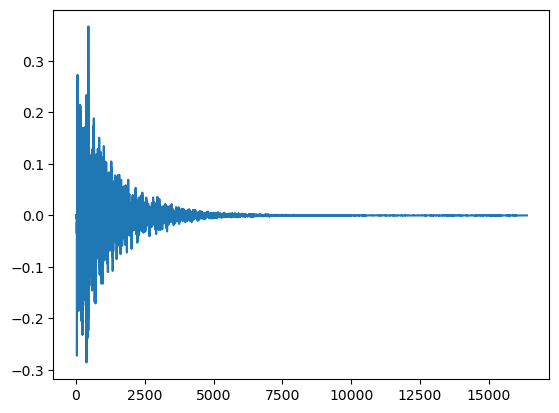

In [5]:
# plot one of the RIRs

plt.plot(dataset[0].squeeze().numpy())

## Coding up GAN

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Conv1dTranspose(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=4, padding='same', upsample='zeros'):
        super(Conv1dTranspose, self).__init__()
        self.upsample = upsample
        self.stride = stride
        self.kernel_size = kernel_size
        if self.upsample == 'zeros':
            self.deconv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=stride, padding = (kernel_size // 2 - 1), output_padding=1)
        elif self.upsample == 'nn':
            self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=(kernel_size // 2))
        else:
            raise NotImplementedError

    def forward(self, x):
        if self.upsample == 'zeros':
            return self.deconv(x)
        elif self.upsample == 'nn':
            x = F.interpolate(x, scale_factor=self.stride, mode='nearest')
            return self.conv(x)


class WaveGANGenerator(nn.Module):
    def __init__(self, z_dim=100, slice_len=16384, nch=1, kernel_len=25, dim=64, use_batchnorm=False, upsample='zeros'):
        super(WaveGANGenerator, self).__init__()
        assert slice_len in [16384, 32768, 65536]
        dim_mul = 16 if slice_len == 16384 else 32
        self.dim_mul = dim_mul
        self.use_batchnorm = use_batchnorm
        self.upsample = upsample
        self.dim = dim
        
        # Projection and reshape
        self.fc = nn.Linear(z_dim, 16 * dim * dim_mul)
        
        # Layers
        self.upconv_0 = Conv1dTranspose(dim * dim_mul, dim * (dim_mul // 2), kernel_len, stride=4, upsample=upsample)
        self.upconv_1 = Conv1dTranspose(dim * (dim_mul // 2), dim * (dim_mul // 4), kernel_len, stride=4, upsample=upsample)
        self.upconv_2 = Conv1dTranspose(dim * (dim_mul // 4), dim * (dim_mul // 8), kernel_len, stride=4, upsample=upsample)
        self.upconv_3 = Conv1dTranspose(dim * (dim_mul // 8), dim * (dim_mul // 16), kernel_len, stride=4, upsample=upsample)
        
        if slice_len == 16384:
            self.upconv_4 = Conv1dTranspose(dim * (dim_mul // 16), nch, kernel_len, stride=4, upsample=upsample)
        elif slice_len == 32768:
            self.upconv_4 = Conv1dTranspose(dim * (dim_mul // 16), dim, kernel_len, stride=4, upsample=upsample)
            self.upconv_5 = Conv1dTranspose(dim, nch, kernel_len, stride=2, upsample=upsample)
        elif slice_len == 65536:
            self.upconv_4 = Conv1dTranspose(dim * (dim_mul // 16), dim, kernel_len, stride=4, upsample=upsample)
            self.upconv_5 = Conv1dTranspose(dim, nch, kernel_len, stride=4, upsample=upsample)

        self.batchnorm = nn.BatchNorm1d if use_batchnorm else lambda x: x
        
    def forward(self, z):
        # FC and reshape for convolution
        output = self.fc(z)
        # print(output.shape)
        output = output.view(-1, self.dim_mul * self.dim, 16)
        # print(output.shape)
        output = F.relu(self.batchnorm(output))
        # output = output.transpose(1, 2)
        # print(output.shape)

        # Layer 0
        output = F.relu(self.batchnorm(self.upconv_0(output)))
        # print(output.shape)
        
        # Layer 1
        output = F.relu(self.batchnorm(self.upconv_1(output)))
        
        # Layer 2
        output = F.relu(self.batchnorm(self.upconv_2(output)))
        
        # Layer 3
        output = F.relu(self.batchnorm(self.upconv_3(output)))
        
        if hasattr(self, 'upconv_5'):
            output = F.relu(self.batchnorm(self.upconv_4(output)))
            output = torch.tanh(self.upconv_5(output))
        else:
            output = torch.tanh(self.upconv_4(output))

        return output


class WaveGANDiscriminator(nn.Module):
    def __init__(self, slice_len=16384, kernel_len=25, dim=64, use_batchnorm=False, phaseshuffle_rad=0):
        super(WaveGANDiscriminator, self).__init__()
        assert slice_len in [16384, 32768, 65536]
        self.dim = dim
        self.kernel_len = kernel_len
        self.use_batchnorm = use_batchnorm
        self.phaseshuffle_rad = phaseshuffle_rad

        self.conv_0 = nn.Conv1d(1, dim, kernel_len, stride=4, padding=(kernel_len // 2))
        self.conv_1 = nn.Conv1d(dim, dim * 2, kernel_len, stride=4, padding=(kernel_len // 2))
        self.conv_2 = nn.Conv1d(dim * 2, dim * 4, kernel_len, stride=4, padding=(kernel_len // 2))
        self.conv_3 = nn.Conv1d(dim * 4, dim * 8, kernel_len, stride=4, padding=(kernel_len // 2))
        self.conv_4 = nn.Conv1d(dim * 8, dim * 16, kernel_len, stride=4, padding=(kernel_len // 2))

        if slice_len in [32768, 65536]:
            self.conv_5 = nn.Conv1d(dim * 16, dim * 32, kernel_len, stride=(4 if slice_len == 65536 else 2), padding=(kernel_len // 2))

        self.fc = nn.Linear(dim * 16 * (slice_len // (4 ** 5)), 1)
        self.batchnorm = nn.BatchNorm1d if use_batchnorm else lambda x: x

    def forward(self, x):
        output = F.leaky_relu(self.conv_0(x), 0.2)
        output = self.phaseshuffle(output)
        output = F.leaky_relu(self.batchnorm(self.conv_1(output)), 0.2)
        output = self.phaseshuffle(output)
        output = F.leaky_relu(self.batchnorm(self.conv_2(output)), 0.2)
        output = self.phaseshuffle(output)
        output = F.leaky_relu(self.batchnorm(self.conv_3(output)), 0.2)
        output = self.phaseshuffle(output)
        output = F.leaky_relu(self.batchnorm(self.conv_4(output)), 0.2)

        if hasattr(self, 'conv_5'):
            output = F.leaky_relu(self.batchnorm(self.conv_5(output)), 0.2)

        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output
    
    def phaseshuffle(self, x):
        if self.phaseshuffle_rad > 0:
            phase = torch.randint(-self.phaseshuffle_rad, self.phaseshuffle_rad + 1, (1,)).item()
            if phase > 0:
                x = F.pad(x, (phase, 0), mode='reflect')
                x = x[:, :, :-phase]
            elif phase < 0:
                x = F.pad(x, (0, -phase), mode='reflect')
                x = x[:, :, -phase:]
        return x


In [7]:
# model summary

gen = WaveGANGenerator()
disc = WaveGANDiscriminator()

batch_size = 16
print(summary(gen, input_size=(batch_size, 100)))

print(summary(disc, input_size=(batch_size, 1, 16384)))


Layer (type:depth-idx)                   Output Shape              Param #
WaveGANGenerator                         [16, 1, 16384]            --
├─Linear: 1-1                            [16, 16384]               1,654,784
├─Conv1dTranspose: 1-2                   [16, 512, 64]             --
│    └─ConvTranspose1d: 2-1              [16, 512, 64]             13,107,712
├─Conv1dTranspose: 1-3                   [16, 256, 256]            --
│    └─ConvTranspose1d: 2-2              [16, 256, 256]            3,277,056
├─Conv1dTranspose: 1-4                   [16, 128, 1024]           --
│    └─ConvTranspose1d: 2-3              [16, 128, 1024]           819,328
├─Conv1dTranspose: 1-5                   [16, 64, 4096]            --
│    └─ConvTranspose1d: 2-4              [16, 64, 4096]            204,864
├─Conv1dTranspose: 1-6                   [16, 1, 16384]            --
│    └─ConvTranspose1d: 2-5              [16, 1, 16384]            1,601
Total params: 19,065,345
Trainable params: 19,065,

## Training GAN

In [9]:

# Function for training the GAN
def train_gan(data_dir, train_batch_size=64, epochs=20, latent_dim=100, lr=0.0001, data_slice_len=16384):
    # Load dataset
    dataset = RIRDataset(data_dir, slice_len=data_slice_len)
    dataloader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)
    
    # Instantiate generator and discriminator
    generator = WaveGANGenerator()
    discriminator = WaveGANDiscriminator()
    
    # Define loss function and optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

    LAMBDA = 10
    
    # Training loop
    for epoch in range(epochs):
        for i, x in enumerate(dataloader):
            batch_size = x.size(0)
            
            # Train discriminator
            z = torch.rand(batch_size, latent_dim) * 2 - 1
            G_z = generator(z) # Generate fake data
            
            # Labels
            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            
            # Discriminator loss on real data
            optimizer_d.zero_grad()
            D_x = discriminator(x) # Discriminate real data
            d_real_loss = -torch.mean(D_x)

            # Discriminator loss on fake data
            D_G_z = discriminator(G_z)
            d_fake_loss = torch.mean(D_G_z)

            # Combine losses
            d_loss = d_real_loss + d_fake_loss

            # Gradient penalty
            alpha = torch.rand(x.size(0), 1, 1).to(x.device)
            interpolates = alpha * x + ((1 - alpha) * G_z.detach())
            interpolates.requires_grad_(True)

            d_interpolates = discriminator(interpolates)

            gradients = autograd.grad(
                outputs=d_interpolates,
                inputs=interpolates,
                grad_outputs=torch.ones(d_interpolates.size()).to(x.device),
                create_graph=True,
                retain_graph=True,
                only_inputs=True
            )[0]

            gradients = gradients.view(gradients.size(0), -1)
            slopes = torch.sqrt(torch.sum(gradients ** 2, dim=1))
            gradient_penalty = torch.mean((slopes - 1) ** 2)
            
            d_loss += LAMBDA * gradient_penalty

            d_loss.backward()
            optimizer_d.step()
            
            # Train generator

            G_z = generator(z) # Generate fake data
            D_G_z = discriminator(G_z)

            # Generator loss
            g_loss = -torch.mean(D_G_z)

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()
            
            # Print progress
            if i % 2 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], \
                      D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
                
            # Save model checkpoints
            torch.save(generator.state_dict(), f"generator.pt")
            torch.save(discriminator.state_dict(), f"discriminator.pt")


# Set default values for training parameters
data_dir = '../data/RIR'  # Directory containing RIR wav files
train_batch_size = 64
epochs = 48
latent_dim = 100
lr = 0.0001
data_slice_len = 16384

# Train GAN
train_gan(data_dir, train_batch_size, epochs, latent_dim, lr, data_slice_len)

Epoch [1/50], Step [1/15],                       D Loss: 9.8764, G Loss: 0.0315
Epoch [1/50], Step [3/15],                       D Loss: 9.5606, G Loss: 0.2518
Epoch [1/50], Step [5/15],                       D Loss: 8.9251, G Loss: -0.3011
Epoch [1/50], Step [7/15],                       D Loss: 12.5531, G Loss: -1.3200
Epoch [1/50], Step [9/15],                       D Loss: 9.5217, G Loss: 2.5956
Epoch [1/50], Step [11/15],                       D Loss: -0.2552, G Loss: 24.9135
Epoch [1/50], Step [13/15],                       D Loss: -4.3032, G Loss: 16.7101
Epoch [1/50], Step [15/15],                       D Loss: 8.2748, G Loss: -4.7681
Epoch [2/50], Step [1/15],                       D Loss: 7.9415, G Loss: -5.7805
Epoch [2/50], Step [3/15],                       D Loss: 6.7379, G Loss: -6.4793
Epoch [2/50], Step [5/15],                       D Loss: 2.9571, G Loss: -6.0312
Epoch [2/50], Step [7/15],                       D Loss: -5.1518, G Loss: 3.4828
Epoch [2/50], Step [9/15]

/var/folders/7_/z3hv83y130nbrvjs_38bl4hr0000gn/T/ipykernel_26793/2257522842.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generat

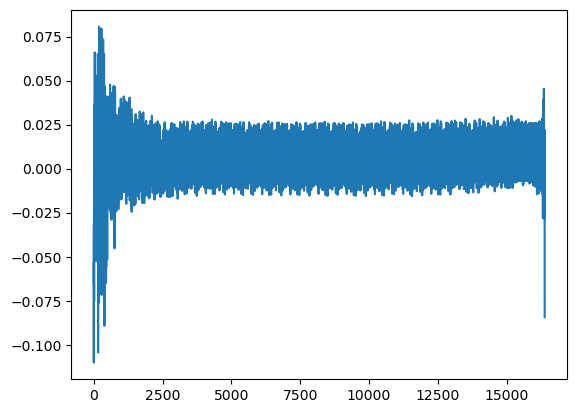

In [11]:
# listen to generated RIRs
z = torch.rand(1, latent_dim) * 2 - 1
generator = WaveGANGenerator()
generator.load_state_dict(torch.load("generator.pt"))
generator.eval()
G_z = generator(z)
G_z = G_z.squeeze().detach().numpy()

ipd.Audio(G_z, rate=16000)

plt.plot(G_z)

## Listen to the RIR convolved with audio

In [16]:
# load violin audio
audio, fs  = librosa.load("../data/violin.wav", sr=16000)

# play violin audio
ipd.Audio(audio[:3*fs], rate=16000)

In [17]:
# convolve with a violin audio
out = np.convolve(audio[:3*fs], G_z)

# play first 3 seconds
out = out[:3*fs]
ipd.Audio(out, rate=16000)

For evaluating the RIRs, we can use the Matlab toolbox [Impulse response acoustic information calculator](https://www.mathworks.com/matlabcentral/fileexchange/42566-impulse-response-acoustic-information-calculator).

## Extended Reading


Ratnarajah, A., Zhang, S. X., Yu, M., Tang, Z., Manocha, D., & Yu, D. (2022, May). FAST-RIR: Fast neural diffuse room impulse response generator. In ICASSP 2022-2022 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 571-575). IEEE.

Fernandez-Grande, E., Karakonstantis, X., Caviedes-Nozal, D., & Gerstoft, P. (2023). [Generative models for sound field reconstruction.](https://pubs.aip.org/asa/jasa/article/153/2/1179/2866890) The Journal of the Acoustical Society of America, 153(2), 1179-1190.